In [29]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

df = pd.read_csv("phiusiil+phishing+url+dataset.zip", compression="zip")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


### Feature Engineering

In [30]:
# Adding a feature to calculate the ratio of domain length to URL length
from collections import Counter
import math
df['DomainToURLLengthRatio'] = df['DomainLength'] / df['URLLength']

# Adding a feature for String Entropy -- measures amount of "randomness" in a URL string
def calc_entropy(url):
    if not url:
        return 0
    # count frequencies
    freqs = Counter(url)
    probabilities = [count / len(url) for count in freqs.values()]

    # Shannon entropy formula: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    entropy = -sum(p * math.log2(p) for p in probabilities)
    return entropy
df['Entropy'] = df['URL'].apply(calc_entropy)


### Cleaning the Data

In [31]:
'''
FILENAME dropped since its not relevant to the data and url is removed since 
useful information from url is already extracted into feature columns
'''
df = df.drop(['FILENAME', 'URL', 'Domain', 'Title'], axis=1)

#TLD can be dropped or kept depending on how useful it is for the models, should do testing including and removing it
#df = df.drop(['TLD'], axis=1)
label_encoder = LabelEncoder()
df['TLD'] = label_encoder.fit_transform(df['TLD'])

In [32]:
df.isnull()
df.duplicated()
df = df.dropna()
df = df.drop_duplicates()

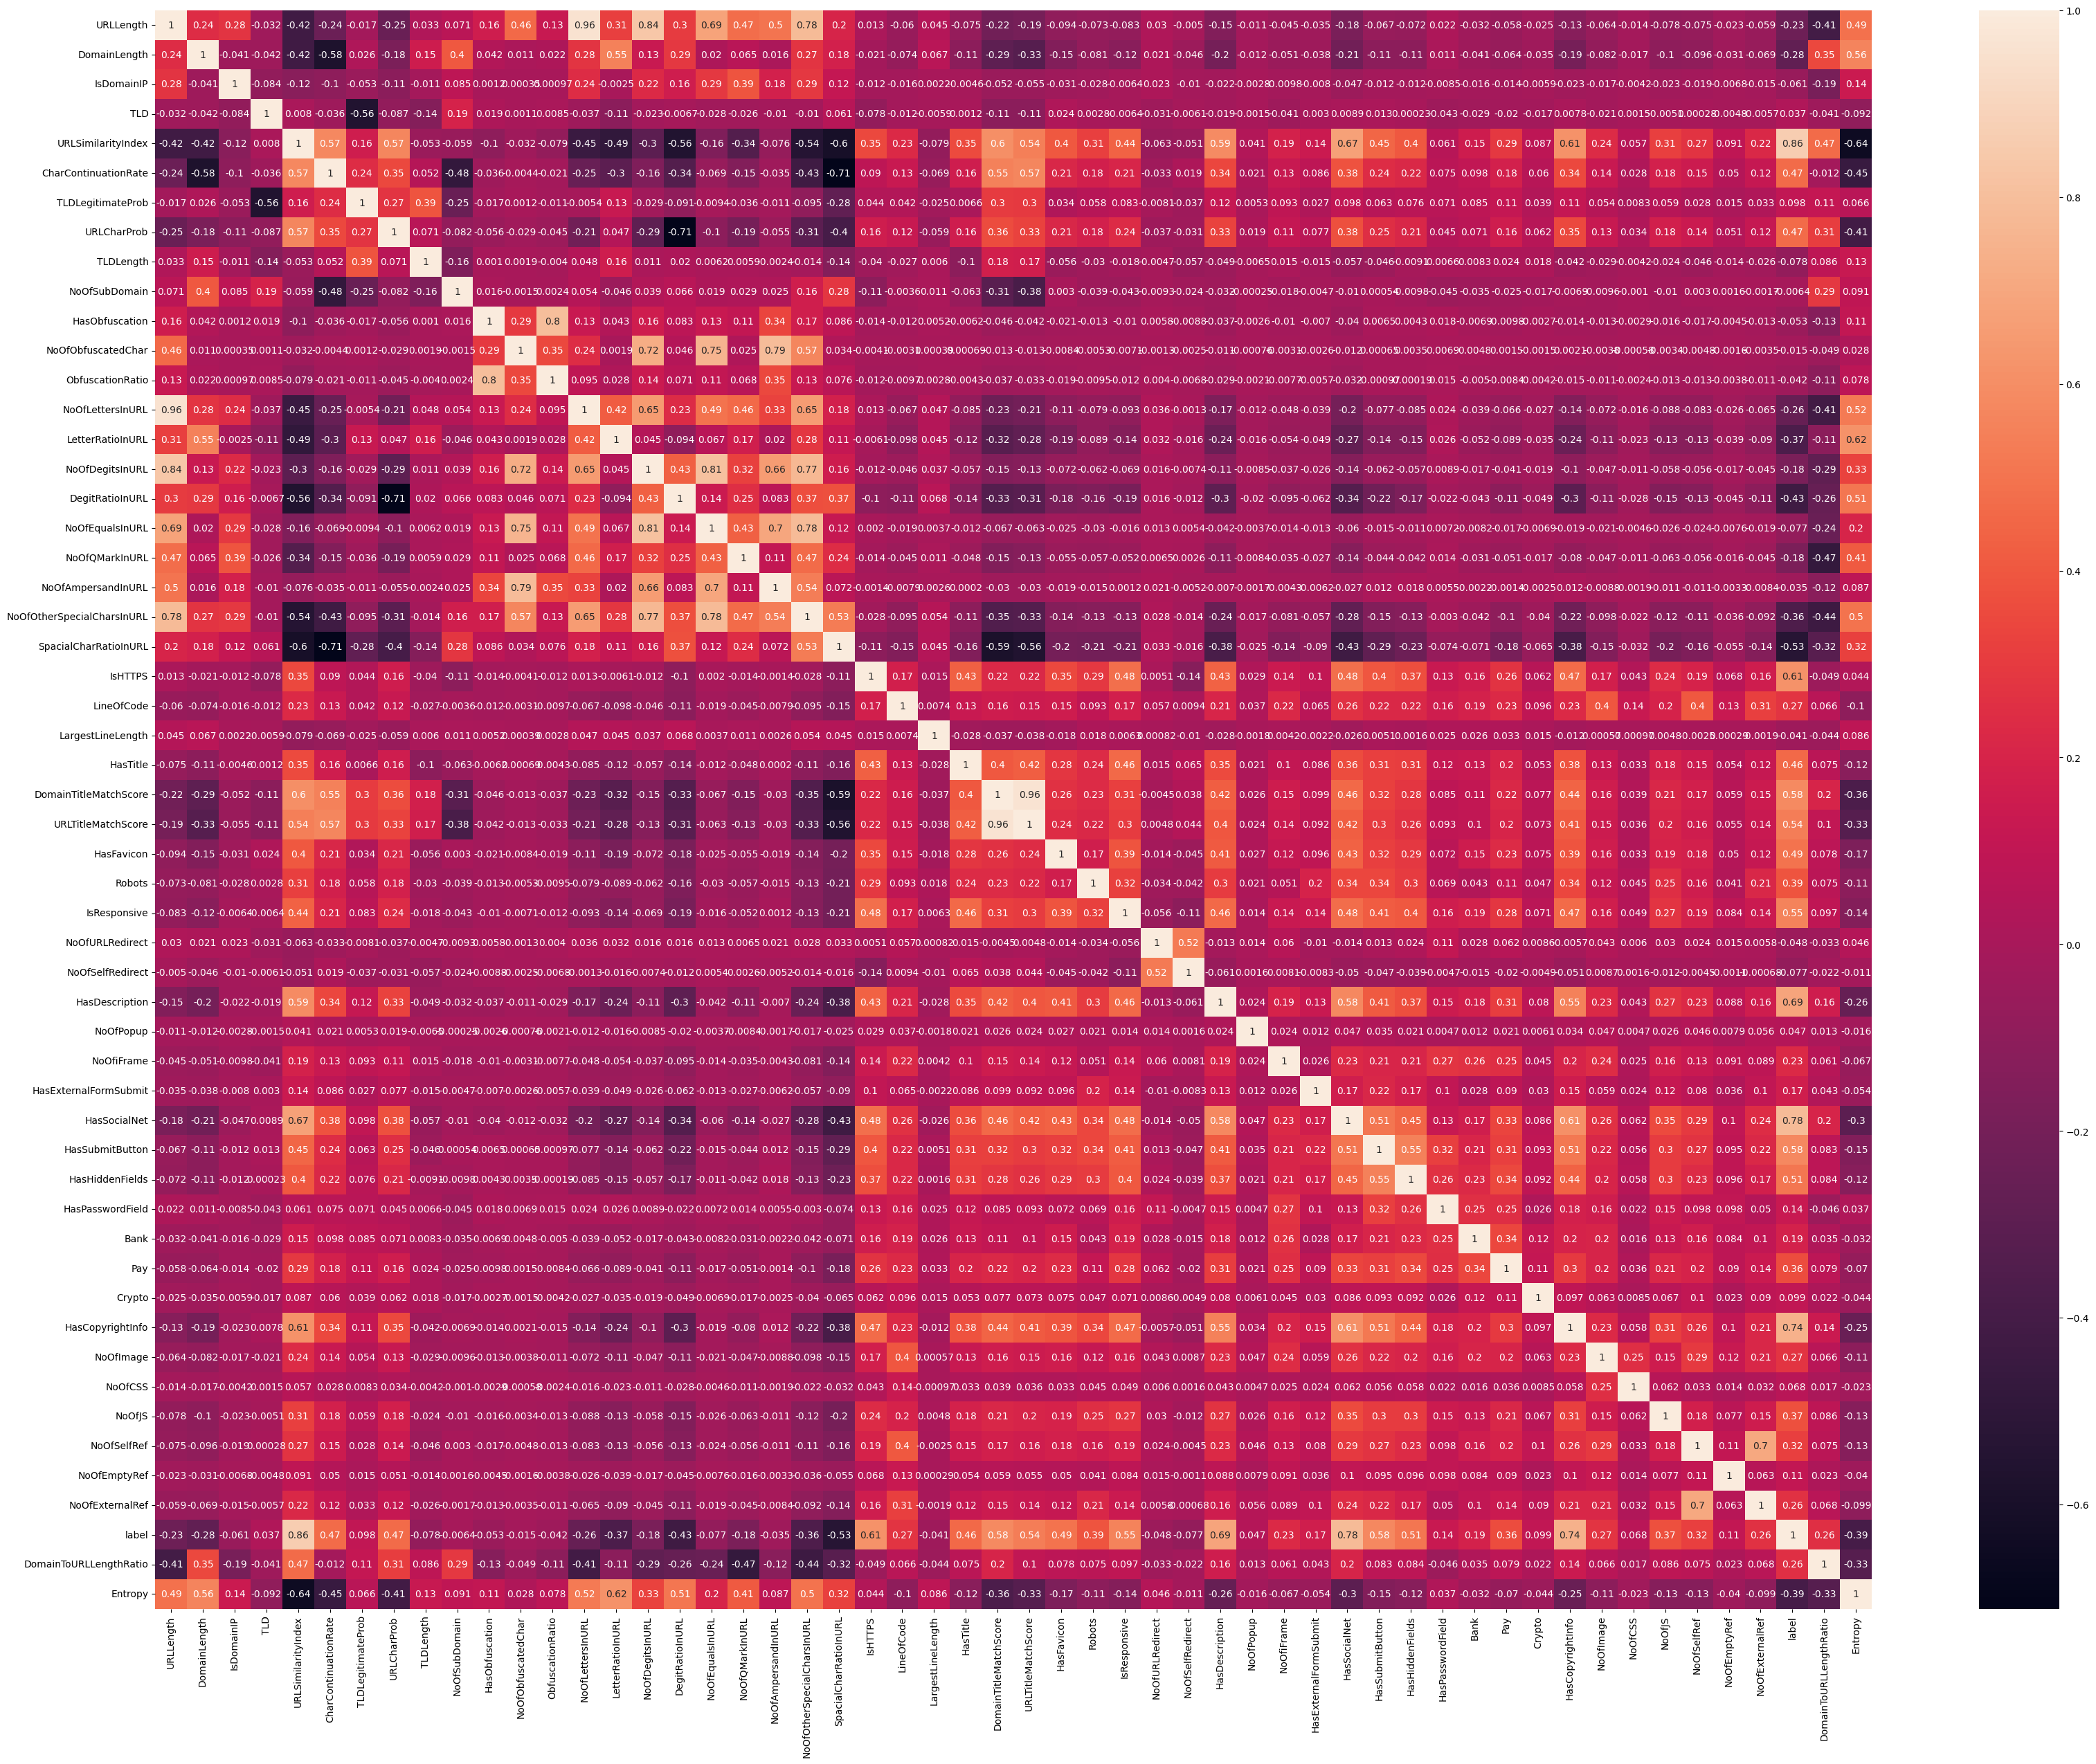

In [33]:
corr = df.corr()
plt.figure(figsize=(40, 30))
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

In [34]:
#Dropping highly corrrelated features
# prof said only to drop for logistic regression
df = df.drop(['URLTitleMatchScore', 'URLLength', 'NoOfAmpersandInURL', 'NoOfLettersInURL'], axis=1) 

In [35]:
features_cleaned = df.copy()
for column in features_cleaned.columns:
    if df[column].nunique() <= 2 or column == 'label':
        continue

    #These features are the only one with reasonable data spreads
    if (column == 'DomainLength' or column == 'URLCharProb' or column == 'LetterRatioInURL' or column == 'SpacialCharRatioInURL'):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        #df[column].hist(bins=50)
        #plt.show()

        #Identifing outliers (points outside the bounds)
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        #Remove the outliers from the DataFrame
        features_cleaned = features_cleaned[(features_cleaned[column] >= lower_bound) & (features_cleaned[column] <= upper_bound)]


In [36]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
import numpy as np

smaller_sample = features_cleaned.sample(frac=0.1, random_state=42)
final_features = smaller_sample.drop(['label'], axis=1)
target = smaller_sample['label']
print("Initial class distribution:")
print(target.value_counts())

original_feature_names = final_features.columns
standard_scale = StandardScaler()
final_features = standard_scale.fit_transform(final_features)
final_features = pd.DataFrame(final_features, columns=original_feature_names)

final_features = final_features.reset_index(drop=True)
target = target.reset_index(drop=True)

smt = SMOTE(random_state=42)
final_features, target = smt.fit_resample(final_features, target)
print("Class distribution after SMOTE:")
print(pd.Series(target).value_counts())

final_features = pd.DataFrame(final_features, columns=original_feature_names)

# took too long for whole dataset
sample_size = 1000
final_features_sample = final_features.sample(n=sample_size, random_state=42)
target_sample = target[final_features_sample.index]

# can change to diff model if needed
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
sfs_forward = SequentialFeatureSelector(
    rf_model,
    direction="forward",
    scoring="average_precision",
    cv=5,
    n_features_to_select="auto",
    n_jobs=-1
)
sfs_forward.fit(final_features_sample, target_sample)

selected_features = final_features.columns[sfs_forward.get_support()]
print("\nSelected features after forward selection:", selected_features)
final_features = final_features[selected_features]

Initial class distribution:
label
1    13299
0     7893
Name: count, dtype: int64
Class distribution after SMOTE:
label
1    13299
0    13299
Name: count, dtype: int64

Selected features after forward selection: Index(['DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
       'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar',
       'ObfuscationRatio', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS',
       'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore'],
      dtype='object')


In [37]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(final_features, target, train_size=0.8, random_state=42)

print("Training set shape:", train_features.shape)
print("Testing set shape:", test_features.shape)

Training set shape: (21278, 24)
Testing set shape: (5320, 24)


In [38]:
# logistic regression. got rid of highly corrlated features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

def find_correlated_features(features, threshold):
    correlation_matrix = features.corr()
    correlated_features = set()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    
    return list(correlated_features)

corr_features = find_correlated_features(train_features, 0.5) 
print("Highly correlated features (> 0.5) to be removed:", corr_features)

train_features_filtered = train_features.drop(columns=corr_features, errors='ignore')
test_features_filtered = test_features.drop(columns=corr_features, errors='ignore')
print(f"\nNumber of features remaining: {train_features_filtered.shape[1]}")

logistic_model_filtered = LogisticRegression(
    random_state=42, 
    max_iter=5000,  
    C=0.001,        
    penalty='l2'
)

logistic_model_filtered.fit(train_features_filtered, train_target)
logistic_predictions_filtered = logistic_model_filtered.predict(test_features_filtered)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(test_target, logistic_predictions_filtered))
print("Classification Report:\n", classification_report(test_target, logistic_predictions_filtered, digits=6))
# cross validation
cv_scores = cross_val_score(logistic_model_filtered, train_features_filtered, train_target, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

Highly correlated features (> 0.5) to be removed: ['ObfuscationRatio', 'SpacialCharRatioInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'TLDLegitimateProb', 'NoOfQMarkInURL', 'LetterRatioInURL', 'DegitRatioInURL', 'NoOfObfuscatedChar', 'DomainTitleMatchScore', 'URLCharProb', 'NoOfOtherSpecialCharsInURL']

Number of features remaining: 12
Logistic Regression Results:
Accuracy: 0.9947368421052631
Classification Report:
               precision    recall  f1-score   support

           0   1.000000  0.989406  0.994675      2643
           1   0.989649  1.000000  0.994797      2677

    accuracy                       0.994737      5320
   macro avg   0.994824  0.994703  0.994736      5320
weighted avg   0.994791  0.994737  0.994737      5320

Cross-validation scores: [0.99506579 0.99389098 0.99459586 0.99294947 0.99341951]
Average CV score: 0.9939843218504546


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

knn_params = {
    'n_neighbors': [1, 3, 5, 7],  
    'leaf_size': [10, 20, 30], 
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_params, cv=5, scoring='recall', n_jobs=-1)
knn_grid_search.fit(train_features, train_target)

best_knn_model = knn_grid_search.best_estimator_
print("Best KNN hyperparameters:", knn_grid_search.best_params_)

knn_predictions = best_knn_model.predict(test_features)
print("KNN accuracy:", accuracy_score(test_target, knn_predictions))
print("KNN classification report:", classification_report(test_target, knn_predictions, digits=6))


Best KNN hyperparameters: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
KNN accuracy: 0.9992481203007518
KNN classification report:               precision    recall  f1-score   support

           0   1.000000  0.998487  0.999243      2643
           1   0.998508  1.000000  0.999253      2677

    accuracy                       0.999248      5320
   macro avg   0.999254  0.999243  0.999248      5320
weighted avg   0.999249  0.999248  0.999248      5320



In [40]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': [None, 'sqrt', 'log2']
}
dt = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(train_features, train_target)

best_dt_model = dt_grid_search.best_estimator_
print("Best dt hyperparameters:", dt_grid_search.best_params_)

dt_predictions = best_dt_model.predict(test_features)
print("DT Accuracy:", accuracy_score(test_target, dt_predictions))
print("DT classification report", classification_report(test_target, dt_predictions, digits=6))


Best dt hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DT Accuracy: 1.0
DT classification report               precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      2643
           1   1.000000  1.000000  1.000000      2677

    accuracy                       1.000000      5320
   macro avg   1.000000  1.000000  1.000000      5320
weighted avg   1.000000  1.000000  1.000000      5320



In [41]:
#mau time pt4
gb_params = {
    'learning_rate': [0.1, 0.2],       
    'n_estimators': [100, 150],        
    'max_depth': [3, 5],               
    'min_samples_split': [2],          
    'min_samples_leaf': [1],           
    'subsample': [0.8]                
}

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats

#random sampling for gradient boosting
gb_params_random = {
    'learning_rate': stats.uniform(0.05, 0.3),  
    'n_estimators': stats.randint(50, 200),
    'max_depth': stats.randint(3, 7),
    'subsample': stats.uniform(0.7, 0.3)
}

gb_random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=gb_params_random,
    n_iter = 20,    
    cv=5,         #cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gb_random_search.fit(train_features_filtered, train_target)
best_gb_model = gb_random_search.best_estimator_
print("Best Parameters (randomized):", gb_random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters (randomized): {'learning_rate': 0.16236203565420876, 'max_depth': 3, 'n_estimators': 64, 'subsample': 0.9195981825434215}


In [43]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(train_features_filtered, train_target)
hgb_predictions = hgb.predict(test_features_filtered)

print("HistGB Accuracy:", accuracy_score(test_target, hgb_predictions))
print("HistGB Classification report:\n", classification_report(test_target, hgb_predictions, digits=6))


HistGB Accuracy: 1.0
HistGB Classification report:
               precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      2643
           1   1.000000  1.000000  1.000000      2677

    accuracy                       1.000000      5320
   macro avg   1.000000  1.000000  1.000000      5320
weighted avg   1.000000  1.000000  1.000000      5320



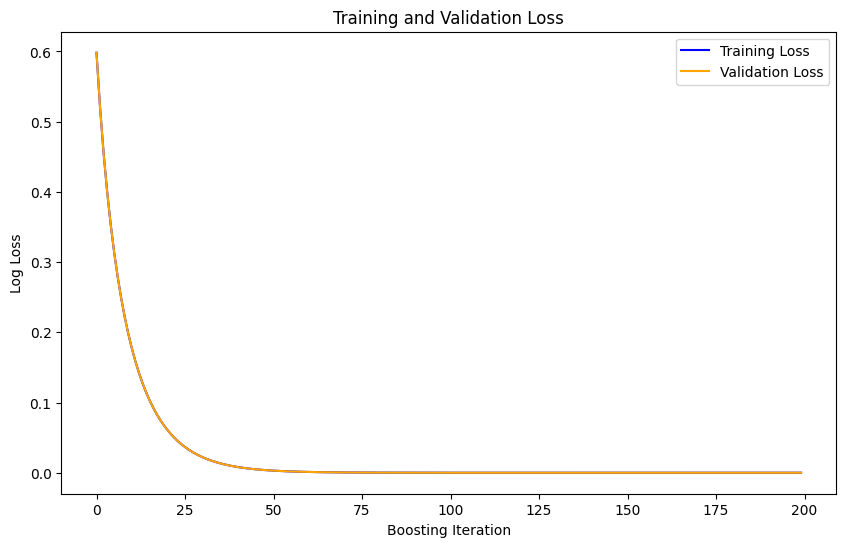

In [44]:
#testing the data to see if model overfits, underfits, or is a good fit
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(train_features_filtered, train_target, test_size=0.2, random_state=42)

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

train_loss = []
val_loss = []

for y_pred_train, y_pred_val in zip(
    gb.staged_predict_proba(X_train), gb.staged_predict_proba(X_val)
):
    train_loss.append(log_loss(y_train, y_pred_train))
    val_loss.append(log_loss(y_val, y_pred_val))

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.xlabel("Boosting Iteration")
plt.ylabel("Log Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

#AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

ada.fit(train_features_filtered, train_target)

ada_pred = ada.predict(test_features_filtered)

print("\nAdaBoost Performance metrics:")
print("Accuracy:", accuracy_score(test_target, ada_pred))
print("Classification Report:\n", classification_report(test_target, ada_pred, digits=6))


C:\Users\RChas\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost Performance metrics:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      2643
           1   1.000000  1.000000  1.000000      2677

    accuracy                       1.000000      5320
   macro avg   1.000000  1.000000  1.000000      5320
weighted avg   1.000000  1.000000  1.000000      5320



In [46]:
from sklearn.model_selection import GridSearchCV
#random forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(train_features_filtered, train_target)

best_rf = rf_grid_search.best_estimator_
rf_best_predictions = best_rf.predict(test_features_filtered)

print("\nTuned Random Forest Performance Metrics:")
print("Best Parameters:", rf_grid_search.best_params_)
print("Accuracy:", accuracy_score(test_target, rf_best_predictions))
print("Classification Report:\n", classification_report(test_target, rf_best_predictions))


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Tuned Random Forest Performance Metrics:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2643
           1       1.00      1.00      1.00      2677

    accuracy                           1.00      5320
   macro avg       1.00      1.00      1.00      5320
weighted avg       1.00      1.00      1.00      5320



In [47]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf, final_features, target, cv=5)
print("Random Forest Cross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())


Random Forest Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average CV Score: 1.0


In [48]:
importances = best_rf.feature_importances_
sorted_indices = importances.argsort()[::-1]
for idx in sorted_indices[:10]:  # Top 10 features
    print(f"Feature: {train_features_filtered.columns[idx]}, Importance: {importances[idx]}")


Feature: URLSimilarityIndex, Importance: 0.41890091765900755
Feature: LineOfCode, Importance: 0.3301020818444412
Feature: LargestLineLength, Importance: 0.10898425070395099
Feature: IsHTTPS, Importance: 0.054560586698191145
Feature: CharContinuationRate, Importance: 0.03114017395471342
Feature: NoOfSubDomain, Importance: 0.022731531291141978
Feature: HasTitle, Importance: 0.021403254521034677
Feature: DomainLength, Importance: 0.006621193863913741
Feature: TLD, Importance: 0.0034142100071981396
Feature: TLDLength, Importance: 0.002013012491449611


### Support Vector Machines

In [ ]:
# SVC Models

# Create the models
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform, randint

linear_svm = SVC(kernel='linear', C=1)
rbf_svm = SVC(kernel='rbf', C=1)

# Train the models
linear_svm.fit(train_features, train_target)
rbf_svm.fit(train_features, train_target)

linear_svm_predictions = linear_svm.predict(test_features)
rbf_svm_predictions = rbf_svm.predict(test_features)

print('linear svm accuracy score:', accuracy_score(test_target, linear_svm_predictions))
print('RBF svm accuracy score:', accuracy_score(test_target, rbf_svm_predictions))


print('linear svm f1 score:', f1_score(test_target, linear_svm_predictions))
print('RBF svm f1 score:', f1_score(test_target, rbf_svm_predictions))

# Implementing Hyper-Parameter Tuning

parameters = {
    'C': loguniform(0.001, 1000),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'degree': randint(1, 10),  
    'gamma': ['scale', 'auto'] + list(loguniform(0.0001, 10).rvs(20)),  
    'coef0': loguniform(0.01, 10),  
    'shrinking': [True, False],  
    'class_weight': [None, 'balanced'],  
}



hyper_svm = SVC()
random_search = RandomizedSearchCV(
    estimator=hyper_svm,
    param_distributions=parameters,
    n_iter=100,  
    cv=5,  # 5-fold cross-validation
    scoring='accuracy', 
    verbose=1,
    random_state=42,
    n_jobs=-1 
)
# random search is commented out to not re-run because it takes a long time to run. Optimal parameters are:
optimal_params = {'C': 3.584985580340472, 'class_weight': None, 'coef0': 3.800329214045199, 'degree': 7, 'gamma': 0.00041089079198622103, 'kernel': 'linear', 'shrinking': True}


# random_search.fit(train_features, train_target)
# print("Optimal Parameters:", random_search.best_params_)
hyper_svm = SVC(**optimal_params)
hyper_svm.fit(train_features, train_target)
hyper_svm_predictions = hyper_svm.predict(test_features)
print('\nAfter hyper-parameter tuning, optimal parameters:', optimal_params)
print('Hyper tuned accuracy score:', accuracy_score(test_target, hyper_svm_predictions))




# e

print("Support Vector Machine (Hyper-tuned model) Classification Report:")
print(classification_report(test_target, hyper_svm_predictions, digits=6))
# cross validation
cv_scores = cross_val_score(hyper_svm, train_features, train_target, cv=5)
print("Cross-validation scores (hyper-tuned svm):", cv_scores)
print("Average CV score (hyper-tuned svm):", cv_scores.mean())








linear svm accuracy score: 0.999624060150376
RBF svm accuracy score: 0.9990601503759399
linear svm f1 score: 0.9996265870052278
RBF svm f1 score: 0.9990662931839402

After hyper-parameter tuning, optimal parameters: {'C': 3.584985580340472, 'class_weight': None, 'coef0': 3.800329214045199, 'degree': 7, 'gamma': 0.00041089079198622103, 'kernel': 'linear', 'shrinking': True}
Hyper tuned accuracy score: 0.999624060150376
Support Vector Machine (Hyper-tuned model) Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.999243  0.999621      2643
           1   0.999253  1.000000  0.999627      2677

    accuracy                       0.999624      5320
   macro avg   0.999627  0.999622  0.999624      5320
weighted avg   0.999624  0.999624  0.999624      5320

Cross-validation scores (hyper-tuned svm): [1.         0.99976504 1.         1.         1.        ]
Average CV score (hyper-tuned svm): 0.999953007518797
